In [1]:
import pandas as pd
from sklearn import datasets, metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 讀取資料

In [2]:
data_path = 'C:\\Users\\USER\\ml100marathon\\'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

In [326]:
df_train.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

# 資料清洗

In [327]:
# 觀察資料後發現一個看起來不像人名，另一個則是全都是 NAN
df_train =  df_train[(df_train['name'] != "THE TRAVEL AGENCY IN THE PARK") & (df_train['name'] != "LOCKHART EUGENE E")]

In [328]:
df_train.shape

(111, 22)

In [329]:
df_train.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


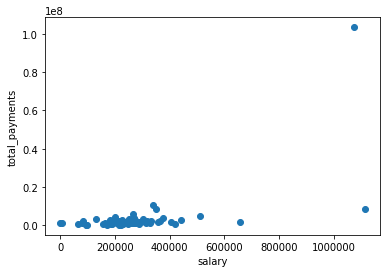

In [330]:
# Scatter plot for salary & total_payments, 看起來右上跟右上有兩個 outlier
plt.scatter(df_train['salary'] , df_train['total_payments'])
plt.xlabel("salary")
plt.ylabel("total_payments")
plt.show()

In [331]:
df_train[(df_train['salary'] > 1000000)]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,...,3600000.0,10359729.0,True,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0


In [332]:
# 刪除 outlier
df_train =  df_train[(df_train['name'] != "SKILLING JEFFREY K") & (df_train['name'] != "LAY KENNETH L")]

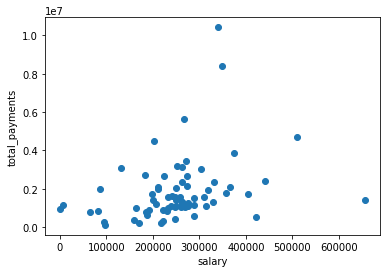

In [333]:
plt.scatter(df_train['salary'] , df_train['total_payments'])
plt.xlabel("salary")
plt.ylabel("total_payments")
plt.show()

In [334]:
df_train.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,5.900000e+01,2.700000e+01,3.300000e+01,13.000000,7.900000e+01,71.000000,63.000000,63.000000,63.000000,1.0,4.700000e+01,6.600000e+01,8.000000e+01,10.000000,71.000000,63.000000,63.000000,9.300000e+01,9.600000e+01
mean,9.727732e+05,6.504199e+05,-4.674926e+05,89397.846154,2.382192e+06,50659.042254,731.619048,63.507937,40.634921,400000.0,7.088987e+05,3.047165e+05,1.057159e+06,-221885.700000,250863.450704,1075.968254,2099.111111,1.463755e+06,2.817245e+06
std,1.174865e+06,8.725079e+05,8.215732e+05,41143.391399,4.539131e+06,47846.473464,2104.452173,92.984194,90.261323,NaN,8.582156e+05,5.896529e+05,1.912355e+06,205191.374121,103193.856343,1166.435374,2837.264250,1.654313e+06,4.994025e+06
min,7.000000e+04,-1.025000e+05,-3.504386e+06,3285.000000,3.285000e+03,148.000000,12.000000,0.000000,0.000000,400000.0,7.102300e+04,2.000000e+00,4.409300e+04,-560222.000000,477.000000,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.250000e+05,7.541900e+04,-5.750000e+05,101250.000000,3.926030e+05,17674.000000,19.000000,10.000000,0.000000,400000.0,2.750000e+05,9.532500e+02,2.629865e+05,-389621.750000,204038.000000,152.500000,510.500000,2.497870e+05,4.164338e+05
50%,7.000000e+05,1.874690e+05,-1.137840e+05,108579.000000,8.254640e+05,41953.000000,45.000000,25.000000,6.000000,400000.0,3.753040e+05,5.198450e+04,4.517400e+05,-139856.500000,250100.000000,589.000000,936.000000,1.101393e+06,9.860165e+05
75%,1.000000e+06,8.371115e+05,-2.500000e+04,112492.000000,2.046177e+06,58506.500000,218.000000,70.500000,26.000000,400000.0,7.891040e+05,3.423098e+05,9.522412e+05,-77953.250000,288550.000000,1788.500000,2622.500000,1.934359e+06,2.335480e+06
max,8.000000e+06,2.964506e+06,-1.042000e+03,125034.000000,3.076606e+07,228763.000000,14368.000000,528.000000,411.000000,400000.0,5.145434e+06,2.818454e+06,1.384707e+07,44093.000000,655037.000000,4527.000000,15149.000000,1.042576e+07,3.076606e+07


In [335]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 112
Data columns (total 22 columns):
name                         109 non-null object
bonus                        59 non-null float64
deferral_payments            27 non-null float64
deferred_income              33 non-null float64
director_fees                13 non-null float64
email_address                81 non-null object
exercised_stock_options      79 non-null float64
expenses                     71 non-null float64
from_messages                63 non-null float64
from_poi_to_this_person      63 non-null float64
from_this_person_to_poi      63 non-null float64
loan_advances                1 non-null float64
long_term_incentive          47 non-null float64
other                        66 non-null float64
poi                          109 non-null bool
restricted_stock             80 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       71 non-null float64
shared_receipt_wi

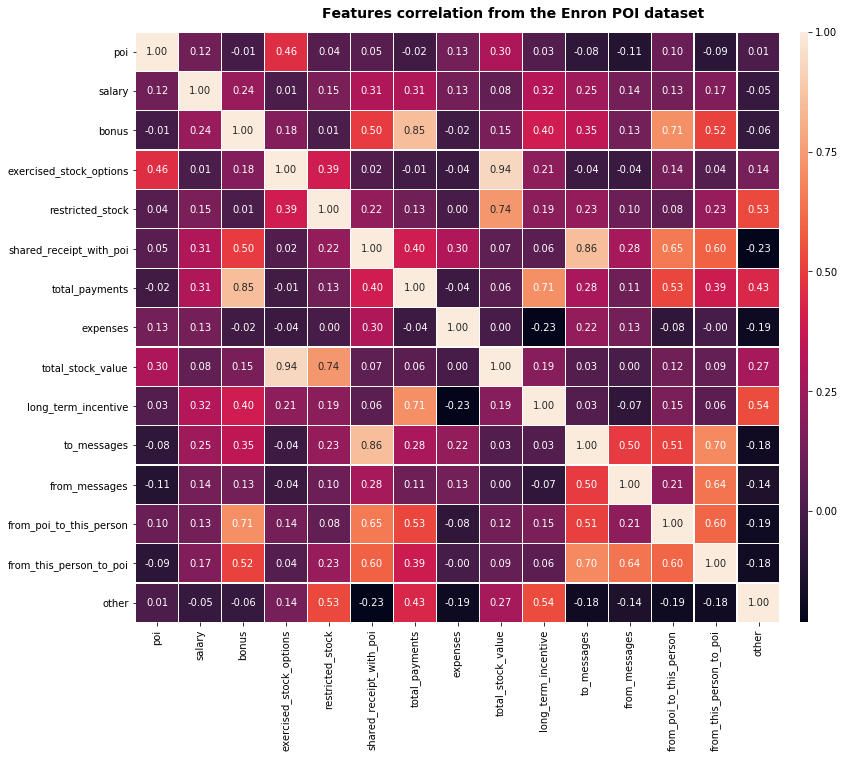

In [336]:
# name,email這種形同ID的欄位先去除,['loan_advances','restricted_stock_deferred','director_fees','deferral_payments','deferred_income']則因為太多缺失值也刪除,剩餘特徵做熱像圖檢視相關性
allFeatures = ['poi','salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
               'total_payments', 'expenses', 'total_stock_value',  'long_term_incentive',
               'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']

train_data = df_train[allFeatures]
test_data = df_test[allFeatures[1:]]

correlationDataframe = train_data.corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws)

# 特徵工程

In [337]:
# 將股票資產作特徵組合(我認為嫌疑犯的可能性跟淨值有關係)，故以總資產減去受限的股票資產做特徵工程
train_data['stock_diff'] = train_data['total_stock_value'] - train_data['restricted_stock']
# 我認為公司對員工的費用補助跟獎金是有一定比例關係的，故選擇以除法方式做特徵工程
train_data['reminder_diff'] = train_data['expenses'] / train_data['bonus']


train_data['stock_diff'] = train_data['stock_diff'].fillna(0)
train_data['reminder_diff'] = train_data['reminder_diff'].fillna(0)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [338]:
test_data['stock_diff'] = test_data['total_stock_value'] - test_data['restricted_stock']
test_data['reminder_diff'] = test_data['expenses'] / test_data['bonus']


test_data['stock_diff'] = test_data['stock_diff'].fillna(0)
test_data['reminder_diff'] = test_data['reminder_diff'].fillna(0)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

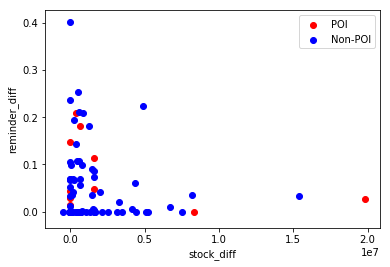

In [339]:
is_poi = (True, False)
colors = ('r', "b")
groups = ("POI", "Non-POI")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for poi, color, group in zip(is_poi, colors, groups):
    data_plot = train_data[train_data['poi'] == poi]
    ax.scatter(data_plot['stock_diff'], data_plot['reminder_diff'], c=color, label=group)
plt.xlabel("stock_diff")
plt.ylabel("reminder_diff")
plt.legend(loc=1)
plt.show()

In [340]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [341]:
y = train_data['poi']

In [342]:
y = y.astype(int)

In [343]:
Features = ['salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
               'total_payments', 'expenses', 'total_stock_value',  'long_term_incentive',
               'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other'
              ,'stock_diff','reminder_diff']
X = train_data[Features]

In [490]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=1)

In [548]:
# 建立模型
clf = GradientBoostingClassifier()

In [549]:
clf.fit(train_X, train_y)
y_pred = clf.predict(val_X)
print("accuracy: %.2f"
      % accuracy_score(val_y, y_pred))

accuracy: 0.93


In [550]:
# 設定要訓練的超參數組合
n_estimators = [100,250,350,400,500]
max_depth = [4, 5 , 6]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(clf, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_y)

# 預設會跑 3-fold cross-validadtion，總共 9 種參數組合，總共要 train 27 次模型

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


In [551]:
# 印出最佳結果與最佳參數
print("ACC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

ACC: 0.839506 using {'max_depth': 5, 'n_estimators': 100}


In [556]:
# 使用最佳參數重新建立模型(經手動測試卻發現深度5 樹250對test預測最好)
clf_bestparam = GradientBoostingClassifier(max_depth=5,
                                           n_estimators=250)

# 訓練模型
clf_bestparam.fit(X , y)

# 預測測試集
y_pred = clf_bestparam.predict_proba(test_data)[:,1]

In [557]:
clf_bestparam.feature_importances_

array([0.00836754, 0.05043932, 0.11302336, 0.01877318, 0.02367891,
       0.06319634, 0.09994539, 0.04262686, 0.00662462, 0.02319026,
       0.01823368, 0.01809915, 0.02083168, 0.25060141, 0.02674067,
       0.12562763])

In [558]:
data = {'name': df_test['name']}
submit = pd.DataFrame(data)
submit['poi'] = y_pred

submit.head()

,name,poi
0,BELDEN TIMOTHY N,0.000167
1,BOWEN JR RAYMOND M,0.981720
2,HANNON KEVIN P,0.030911
3,DELAINEY DAVID W,0.000139
4,CAUSEY RICHARD A,0.024803


In [559]:
submit.to_csv('poi_predGBDTup.csv', index = False)

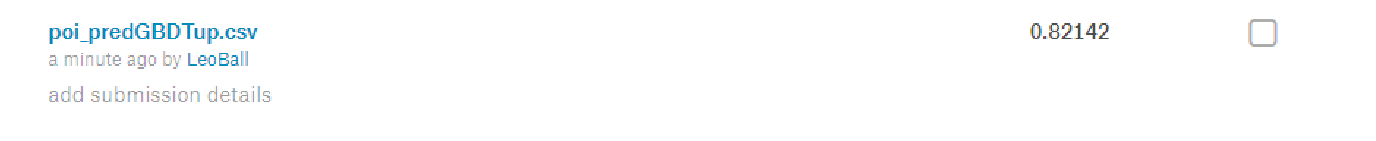

In [560]:
plt.figure(figsize=(24,24)) 
gbdtpred = mpimg.imread('GBDT.png')
plt.imshow(gbdtpred)
plt.axis('off') # 不顯示座標軸
plt.show()

In [229]:
!pip install xgboost

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [230]:
import xgboost as xgb
import seaborn as sns

In [345]:
# 建立模型
clfxgb = xgb.XGBClassifier()

In [477]:
n_estimators = [100,200, 300,400, 500]
max_depth = [2, 3 , 4 , 5 , 6]
scale_pos_weight = [0.4,0.6, 0.8, 1 , 1.5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, scale_pos_weight=scale_pos_weight)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(clfxgb, param_grid, n_jobs=-1, verbose=1 )

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    6.0s finished


In [478]:
grid_result.best_params_

{'max_depth': 2, 'n_estimators': 100, 'scale_pos_weight': 0.4}

In [542]:
# # 使用最佳參數重新建立模型
xgb_bestparam = xgb.XGBClassifier(max_depth= 3, #grid_result.best_params_['max_depth'],
                                  n_estimators=150, #grid_result.best_params_['n_estimators'],
                                  scale_pos_weight=0.6) #grid_result.best_params_['scale_pos_weight'])

# 訓練模型
xgb_bestparam.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.4, seed=None, silent=None,
       subsample=1, verbosity=1)

In [543]:
val_pred = xgb_bestparam.predict(val_X)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [544]:
print(metrics.accuracy_score(val_y, val_pred))

0.9642857142857143


In [ ]:
xgb_bestparam.fit(X, y)

In [534]:
y_pred = xgb_bestparam.predict_proba(test_data)[:,1]

In [535]:
data = {'name': df_test['name']}
submit = pd.DataFrame(data)
submit['poi'] = y_pred

submit.head()

,name,poi
0,BELDEN TIMOTHY N,0.680231
1,BOWEN JR RAYMOND M,0.366430
2,HANNON KEVIN P,0.422395
3,DELAINEY DAVID W,0.067108
4,CAUSEY RICHARD A,0.311814


In [536]:
submit.to_csv('poi_predXGB.csv', index = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text yticklabel objects>)

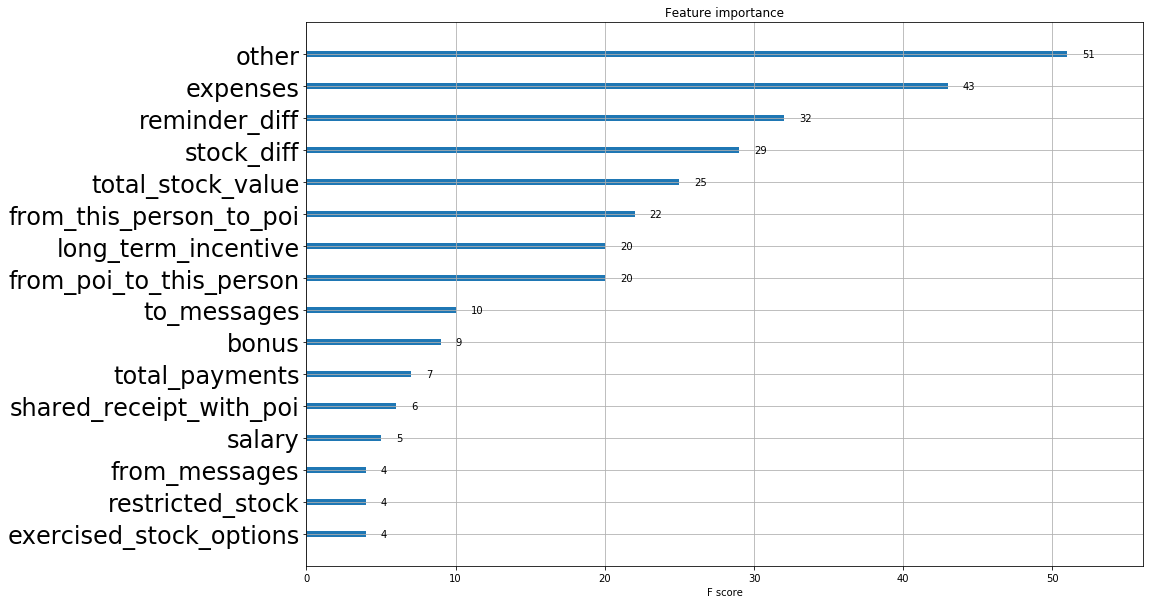

In [521]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(xgb_bestparam, ax=ax, ylabel=None)
plt.yticks(size=24)

In [545]:
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片

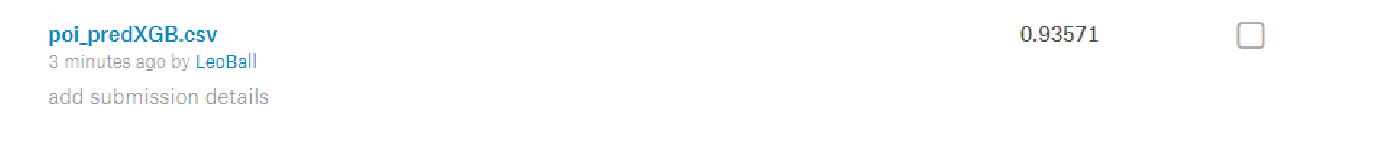

In [547]:
plt.figure(figsize=(24,24)) 
xgbpred = mpimg.imread('XGB.png')
plt.imshow(xgbpred)
plt.axis('off') # 不顯示座標軸
plt.show()